# House Price Prediction

## Importing Libraries

In [142]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import pandas as pd
import urllib
import tarfile
import sklearn
import joblib

from scipy.stats import *
from sklearn import *
from sklearn.model_selection import *

print(tf.__version__)
print(sklearn.__version__)

2.3.0
0.23.2


## Data Acquisition and Visualization

In [2]:
dataset_url = "https://github.com/ageron/handson-ml2/raw/master/datasets/housing/housing.tgz"
data_dir = keras.utils.get_file('housing', origin = dataset_url, untar = True, extract=True)
data_dir = pathlib.Path(data_dir)
# print(data_dir)

In [3]:
df = pd.read_csv(os.path.join(data_dir.parents[0], 'housing.csv'))
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

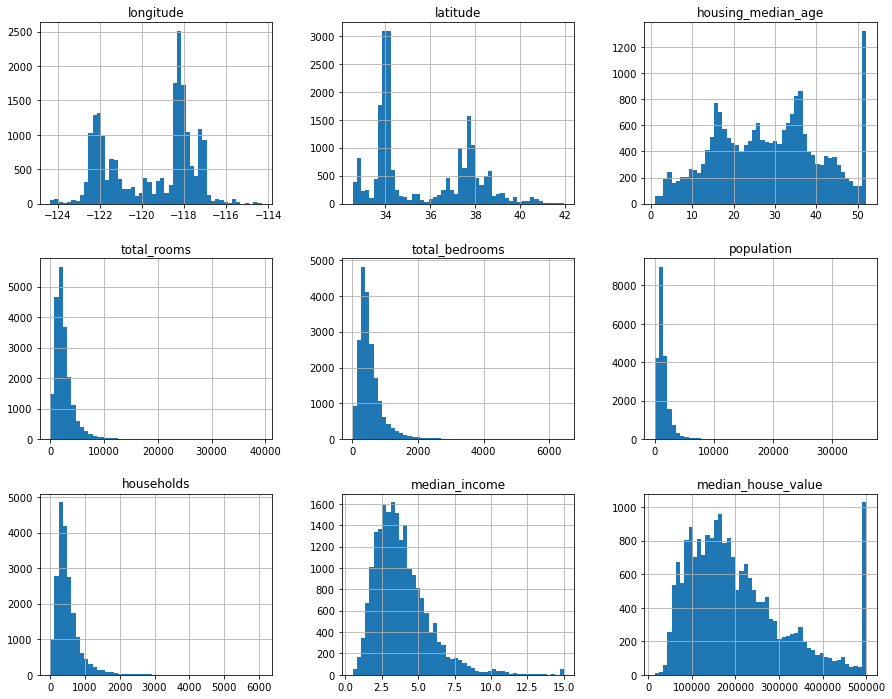

In [6]:
df.hist(bins = 50, figsize = (15,12))
plt.show()

## Data Preprocessing

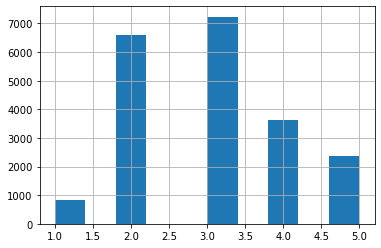

In [7]:
df['income_cat'] = pd.cut(df['median_income'], bins = [0, 1.5, 3, 4.5, 6, np.inf], labels = [1,2,3,4,5])
df['income_cat'].hist()
plt.show()

**Stratified sampling** divides the entire dataset into homogeneous subgroups. This reduces the sampling bias and ensures the test set perserves the statistical distribution of the data (representative).
Shouldn not make too many strata (sufficient samples in each strata), otherwise the importance estimated most likely will be biased.

In [8]:
for train_idx, test_idx in StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(df, df['income_cat']):
    train_ds = df.loc[train_idx]
    test_ds = df.loc[test_idx]

In [9]:
def proportion(data):
    return data['income_cat'].value_counts()/len(data)

train_ds_orig, test_ds_orig = train_test_split(df, test_size = 0.2, random_state = 42)

compare_df = pd.DataFrame({
    'Overall': proportion(df),
    'Stratified': proportion(train_ds),
    'Random': proportion(test_ds_orig)
}).sort_index()

compare_df['Rand Error %'] = compare_df['Random'] / compare_df['Overall'] - 1
compare_df['Stra Error %'] = compare_df['Stratified'] / compare_df['Overall'] - 1
compare_df

,Overall,Stratified,Random,Rand Error %,Stra Error %
1,0.039826,0.039850,0.040213,0.009732,0.000608
2,0.318847,0.318859,0.324370,0.017323,0.000038
3,0.350581,0.350594,0.358527,0.022664,0.000035
4,0.176308,0.176296,0.167393,-0.050563,-0.000069
5,0.114438,0.114402,0.109496,-0.043184,-0.000318


In [10]:
for set_ in (train_ds, test_ds):
    set_.drop('income_cat', axis = 1, inplace = True)

### Data Investigation and Analysis

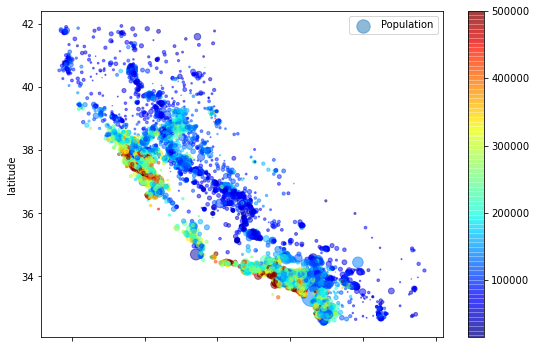

In [11]:
data = train_ds.copy()
data.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.5,
         s = data['population']/100, label = 'Population',
         c = data['median_house_value'], cmap = plt.get_cmap("jet"), figsize = (9,6), colorbar = True)
plt.legend()
plt.show()

In [12]:
corr_matrix = data.corr()
print(corr_matrix['median_house_value'].sort_values(ascending = False))

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64


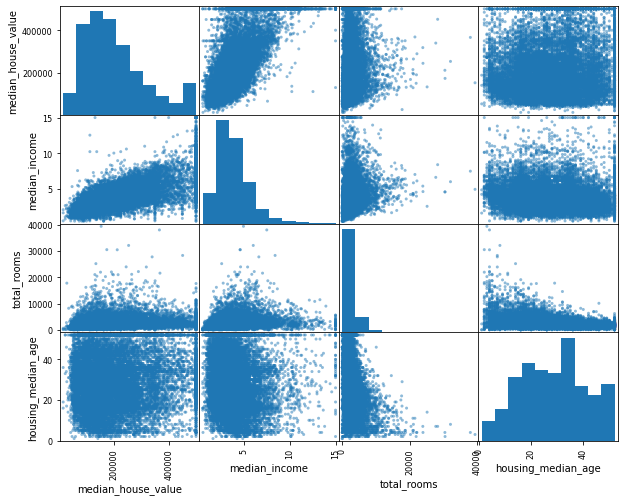

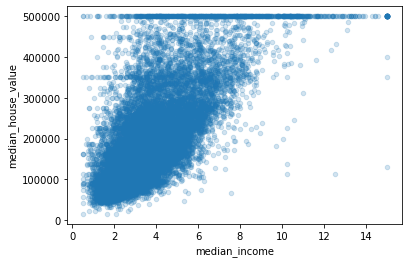

In [13]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(data[attributes], figsize = (10,8))
data.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.2)
plt.show()

In [14]:
data["rooms_per_household"] = data["total_rooms"] / data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"] / data["total_rooms"]
data["population_per_household"] = data["population"] / data["households"]

corr_matrix = data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

It can be noticed that the new features are indeed helpful. For instance, the "rooms_per_household" has a positive correlation (ranks the 3rd place), and it makes sense.

### Data Cleaning

In [15]:
# Separate features and labels
train_ds_x = train_ds.drop("median_house_value", axis = 1)
train_ds_y = train_ds["median_house_value"].copy()

In [16]:
# imputer. Using to fill all the N/A cells
train_ds_x_numeric = train_ds_x.drop('ocean_proximity', axis = 1) # Numerical columns

# Do it individually
imputer = sklearn.impute.SimpleImputer(strategy = 'median')
imputer.fit(train_ds_x_numeric)
X = imputer.transform(train_ds_x_numeric)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [17]:
# Categorical input processing using one-hot-encoder
train_cat = train_ds_x[['ocean_proximity']] # Categorical column

# Do it individually
one_hot_encoder = sklearn.preprocessing.OneHotEncoder()
train_cat_1hot = one_hot_encoder.fit_transform(train_cat)
one_hot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [18]:
# A custom transformer for creating new useful features by combining different features

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6 # from the column indices

class CombineAttribsAdder(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombineAttribsAdder(add_bedrooms_per_room = False)
extra_attribs = attr_adder.transform(train_ds.values)

In [19]:
# Numerical input pipeline
numeric_pipeline = sklearn.pipeline.Pipeline([
    ('imputer', sklearn.impute.SimpleImputer(strategy = 'median')),
    ('attribs_adder', CombineAttribsAdder()),
    ('std_scaler', sklearn.preprocessing.StandardScaler())
])

train_ds_x_num = numeric_pipeline.fit(train_ds_x_numeric)

All in one using the sklearn.ColummTransformer

In [20]:
num_attribs = list(train_ds_x_numeric)
cat_attribs = ["ocean_proximity"]

full_pipeline = sklearn.compose.ColumnTransformer([
    ('num', numeric_pipeline, num_attribs),
    ('cat', sklearn.preprocessing.OneHotEncoder(), cat_attribs)
])

train_ds_x = full_pipeline.fit_transform(train_ds)

# Model Building and Selection

In [104]:
data_pt_input = train_ds_x[:5]
data_pt_label = train_ds_y[:5]

### Linear regression

In [105]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(train_ds_x, train_ds_y)
predictions = lin_reg.predict(data_pt_input)
print("predictions\tTrue Labels")
for i, y_hat in enumerate(predictions):
    print('{:.3f}\t{}'.format(y_hat, data_pt_label.to_numpy()[i]))
lin_rmse = np.sqrt(sklearn.metrics.mean_squared_error(data_pt_label, predictions))
print('RMSE: {:.3f}'.format(lin_rmse))

predictions	True Labels
210644.605	286600.0
317768.807	340600.0
210956.433	196900.0
59218.989	46300.0
189747.558	254500.0
RMSE: 46578.638


### Random Forest

In [106]:
forest_reg = ensemble.RandomForestRegressor()
forest_reg.fit(train_ds_x, train_ds_y)
predictions = forest_reg.predict(data_pt_input)
print("predictions\tTrue Labels")
for i, y_hat in enumerate(predictions):
    print('{:.3f}\t{}'.format(y_hat, data_pt_label.to_numpy()[i]))
forest_rmse = np.sqrt(metrics.mean_squared_error(data_pt_label, predictions))
print('RMSE: {:.3f}'.format(forest_rmse))

predictions	True Labels
259186.000	286600.0
328854.000	340600.0
221934.000	196900.0
49396.000	46300.0
238615.000	254500.0
RMSE: 18857.972


### SVM

In [107]:
svm_reg = svm.SVR(kernel="linear")
svm_reg.fit(train_ds_x, train_ds_y)
predictions = svm_reg.predict(data_pt_input)
print("predictions\tTrue Labels")
for i, y_hat in enumerate(predictions):
    print('{:.3f}\t{}'.format(y_hat, data_pt_label.to_numpy()[i]))
svm_rmse = np.sqrt(metrics.mean_squared_error(data_pt_label, predictions))
print('RMSE: {:.3f}'.format(svm_rmse))

predictions	True Labels
175421.011	286600.0
190268.746	340600.0
175653.267	196900.0
165556.979	46300.0
183911.428	254500.0
RMSE: 104514.737


### Cross-validation

In [108]:
def display_score(scores):
    print("Scores: ", scores)
    print('Mean: ', scores.mean())
    print('STD: ', scores.std())
    print("------------------------------------------------------------")

In [109]:
lin_rmse_score = np.sqrt(-cross_val_score(lin_reg, train_ds_x, train_ds_y, scoring="neg_mean_squared_error", cv=10))
forest_rmse_score = np.sqrt(-cross_val_score(forest_reg, train_ds_x, train_ds_y, scoring="neg_mean_squared_error", cv=10))
svm_rmse_score = np.sqrt(-cross_val_score(svm_reg, train_ds_x, train_ds_y, scoring="neg_mean_squared_error", cv=10))

In [110]:
display_score(lin_rmse_score)
display_score(forest_rmse_score)
display_score(svm_rmse_score)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
STD:  2731.6740017983434
------------------------------------------------------------
Scores:  [49500.78174186 47519.63444107 49866.97178105 52098.64181991
 49805.3641604  53788.9264113  48539.22385948 48193.5496392
 53208.6969429  50258.33818989]
Mean:  50278.012898705565
STD:  2005.092652293203
------------------------------------------------------------
Scores:  [105342.09141998 112489.24624123 110092.35042753 113403.22892482
 110638.90119657 115675.8320024  110703.56887243 114476.89008206
 113756.17971227 111520.1120808 ]
Mean:  111809.84009600841
STD:  2762.393664321567
------------------------------------------------------------


## Fine-tuning

When you have no idea what value a hyperparameter should have, a simple approach is to try out consecutive powers of 10, or a
smaller number if you want a more fine-grained search

### Grid Search

In [111]:
para_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

grid_search = GridSearchCV(forest_reg, para_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)
grid_search.fit(train_ds_x, train_ds_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [112]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [113]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [114]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64155.43935357613 {'max_features': 2, 'n_estimators': 3}
55674.05511785708 {'max_features': 2, 'n_estimators': 10}
53079.92955790299 {'max_features': 2, 'n_estimators': 30}
60629.655370245 {'max_features': 4, 'n_estimators': 3}
52859.90693252803 {'max_features': 4, 'n_estimators': 10}
50771.295451744176 {'max_features': 4, 'n_estimators': 30}
58124.22862012093 {'max_features': 6, 'n_estimators': 3}
51896.95834401236 {'max_features': 6, 'n_estimators': 10}
49956.68422582204 {'max_features': 6, 'n_estimators': 30}
58671.95771354554 {'max_features': 8, 'n_estimators': 3}
51834.978807592444 {'max_features': 8, 'n_estimators': 10}
49991.15828961409 {'max_features': 8, 'n_estimators': 30}
63297.57173250252 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54281.70766975327 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60050.24317375814 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52329.86550149824 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [118]:
feature_importance = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.3027666318944048, 'median_income'),
 (0.14942429111578226, 'INLAND'),
 (0.106639045748298, 'pop_per_hhold'),
 (0.09907640346959565, 'bedrooms_per_room'),
 (0.07814413155643346, 'longitude'),
 (0.06910522060064454, 'latitude'),
 (0.05985620934141126, 'rooms_per_hhold'),
 (0.04316385988934457, 'housing_median_age'),
 (0.017849840325886893, 'total_rooms'),
 (0.017581037846764385, 'population'),
 (0.017131396016589466, 'total_bedrooms'),
 (0.016429837682461788, 'households'),
 (0.012942098150490886, '<1H OCEAN'),
 (0.005826209074613416, 'NEAR OCEAN'),
 (0.0040023122354126105, 'NEAR BAY'),
 (6.147505186605685e-05, 'ISLAND')]

In [165]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]
    

k = 6
top_k_feature_indices = indices_of_top_k(feature_importance, k)
np.array(attributes)[top_k_feature_indices]

[(0.3027666318944048, 'median_income'),
 (0.14942429111578226, 'INLAND'),
 (0.106639045748298, 'pop_per_hhold'),
 (0.09907640346959565, 'bedrooms_per_room'),
 (0.07814413155643346, 'longitude'),
 (0.06910522060064454, 'latitude')]

### Randomized Search

In [117]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_ds_x, train_ds_y)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213EA40DDF0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000213EC77FEE0>},
                   random_state=42, scoring='neg_mean_squared_error')

## Evaulate Model

In [137]:
final_model = grid_search.best_estimator_
test_x = test_ds.drop("median_house_value", axis = 1)
test_y = test_ds["median_house_value"].copy()

test_ds_x = full_pipeline.transform(test_ds)

predictions = final_model.predict(test_ds_x)
final_rmse = np.sqrt(metrics.mean_squared_error(test_y, predictions))
final_rmse

47578.49084547554

In [138]:
confidence = 0.95
squared_err = (test_y - predictions) ** 2
np.sqrt(t.interval(confidence, len(squared_err)-1, loc = squared_err.mean(),
                  scale = sem(squared_err)))

array([45628.26594117, 49451.8647724 ])

In [169]:
full_pipeline_with_predictor = pipeline.Pipeline([
    ('Preparation', full_pipeline),
    ('Random_forest_predictor', final_model)
])

## Save and Load Models

In [170]:
my_model = full_pipeline_with_predictor

joblib.dump(my_model, 'my_RF_model.pkl')

my_model_loaded = joblib.load('my_RF_model.pkl')

In [171]:
n_prediction = my_model_loaded.predict(test_ds)
final_rmse_n = np.sqrt(metrics.mean_squared_error(test_y, n_prediction))
final_rmse_n

47578.49084547554